<a href="https://colab.research.google.com/github/rabnawaz172/Diabetic-Retinopathy/blob/main/DR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/My Drive/Diabetic_Retino/preprocced/'

In [ ]:
import os

# Define paths to train, validation, and test datasets
base_path = '/content/drive/My Drive/Diabetetic_Retino/preprocced/'
train_path = os.path.join(base_path, 'train')

test_path = os.path.join(base_path, 'test')



import cv2
import numpy as np
from tqdm import tqdm

# Load and preprocess images
def load_images_from_folder(folder):
    images = []
    labels = []
    for class_name in os.listdir(folder):
        class_folder = os.path.join(folder, class_name)
        for filename in tqdm(os.listdir(class_folder)):
            img = cv2.imread(os.path.join(class_folder, filename))
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Resize images to 224x224
                images.append(img)
                labels.append(class_name)
    return np.array(images), np.array(labels)

# Load train, validation, and test datasets
X_train, y_train = load_images_from_folder(train_path)

X_test, y_test = load_images_from_folder(test_path)


100%|██████████| 30/30 [00:26<00:00,  1.15it/s]


In [ ]:
from tensorflow.keras.applications import VGG16
# Updated import statement
from skimage.feature import graycomatrix, graycoprops
import cv2
import numpy as np
from tqdm import tqdm

# Extract CNN features
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
cnn_features_train = base_model.predict(X_train)

cnn_features_test = base_model.predict(X_test)

# Extract GLCM features
def extract_glcm_features(images):
    glcm_features = []
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Updated function names from greycomatrix/greycoprops to graycomatrix/graycoprops
        glcm = graycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        glcm_features.append([contrast, homogeneity])
    return np.array(glcm_features)

glcm_features_train = extract_glcm_features(X_train)

glcm_features_test = extract_glcm_features(X_test)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 36s 161ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


CNN Features Reduced to 90

In [ ]:
# Reshape CNN features
from sklearn.model_selection import train_test_split
cnn_features_train_reshaped = cnn_features_train.reshape(cnn_features_train.shape[0], -1)

# Split training data: 90% for training, 10% discarded
cnn_features_train, _, y_train, _ = train_test_split(
    cnn_features_train_reshaped, y_train, test_size=0.15, random_state=42
)

RF with CNN Features Only

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split



# Train model using only 90% of CNN features
rfr_cnn = RandomForestClassifier(n_estimators=100, random_state=42)
rfr_cnn.fit(cnn_features_train, y_train)

# Evaluate model on test set using CNN features
y_test_pred_cnn_rfr = rfr_cnn.predict(cnn_features_test.reshape(cnn_features_test.shape[0], -1))

print("Test Set Evaluation (CNN Features Only):")
print(classification_report(y_test, y_test_pred_cnn_rfr, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))


Test Set Evaluation (CNN Features Only):
                precision    recall  f1-score   support

          Mild       0.81      0.87      0.84        30
      Moderate       0.82      0.90      0.86        30
         No DR       0.81      1.00      0.90        30
Proliferate DR       0.92      0.73      0.81        30
        Severe       0.96      0.77      0.85        30

      accuracy                           0.85       150
     macro avg       0.86      0.85      0.85       150
  weighted avg       0.86      0.85      0.85       150



GNB with CNN Features

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Train Gaussian Naive Bayes (GNB) model using only 20% of CNN features
gnb_cnn = GaussianNB()
gnb_cnn.fit(cnn_features_train, y_train)

# Evaluate model on test set using CNN features
y_test_pred_cnn_gnb = gnb_cnn.predict(cnn_features_test.reshape(cnn_features_test.shape[0], -1))

print("Test Set Evaluation (CNN Features Only,):")
print(classification_report(y_test, y_test_pred_cnn_gnb, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))

Test Set Evaluation (CNN Features Only,):
                precision    recall  f1-score   support

          Mild       0.72      0.60      0.65        30
      Moderate       0.57      0.87      0.68        30
         No DR       0.72      0.87      0.79        30
Proliferate DR       0.77      0.57      0.65        30
        Severe       0.90      0.63      0.75        30

      accuracy                           0.71       150
     macro avg       0.74      0.71      0.71       150
  weighted avg       0.74      0.71      0.71       150



LR with CNN Features

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# Train Logistic Regression model using only 20% of CNN features
logreg_cnn = LogisticRegression(max_iter=500, random_state=42, multi_class='multinomial')
logreg_cnn.fit(cnn_features_train, y_train)

# Evaluate model on test set using CNN features
y_test_pred_cnn_lr = logreg_cnn.predict(cnn_features_test.reshape(cnn_features_test.shape[0], -1))

print("Test Set Evaluation (CNN Features Only,):")
print(classification_report(y_test, y_test_pred_cnn_lr, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Set Evaluation (CNN Features Only,):
                precision    recall  f1-score   support

          Mild       0.92      0.80      0.86        30
      Moderate       0.82      0.93      0.88        30
         No DR       0.86      1.00      0.92        30
Proliferate DR       0.89      0.83      0.86        30
        Severe       0.96      0.87      0.91        30

      accuracy                           0.89       150
     macro avg       0.89      0.89      0.89       150
  weighted avg       0.89      0.89      0.89       150



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DTR with CNN Features

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Train Decision Tree model
dtr_cnn = DecisionTreeClassifier(random_state=42)
dtr_cnn.fit(cnn_features_train, y_train)

# Evaluate model on test set
y_test_pred_cnn_dtr = dtr_cnn.predict(cnn_features_test.reshape(cnn_features_test.shape[0], -1))
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred_cnn_dtr, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))

Test Set Evaluation:
                precision    recall  f1-score   support

          Mild       0.92      0.77      0.84        30
      Moderate       0.79      0.90      0.84        30
         No DR       0.79      1.00      0.88        30
Proliferate DR       0.85      0.77      0.81        30
        Severe       0.92      0.80      0.86        30

      accuracy                           0.85       150
     macro avg       0.86      0.85      0.85       150
  weighted avg       0.86      0.85      0.85       150



Print CNN features based CONFUSION MATRIXS

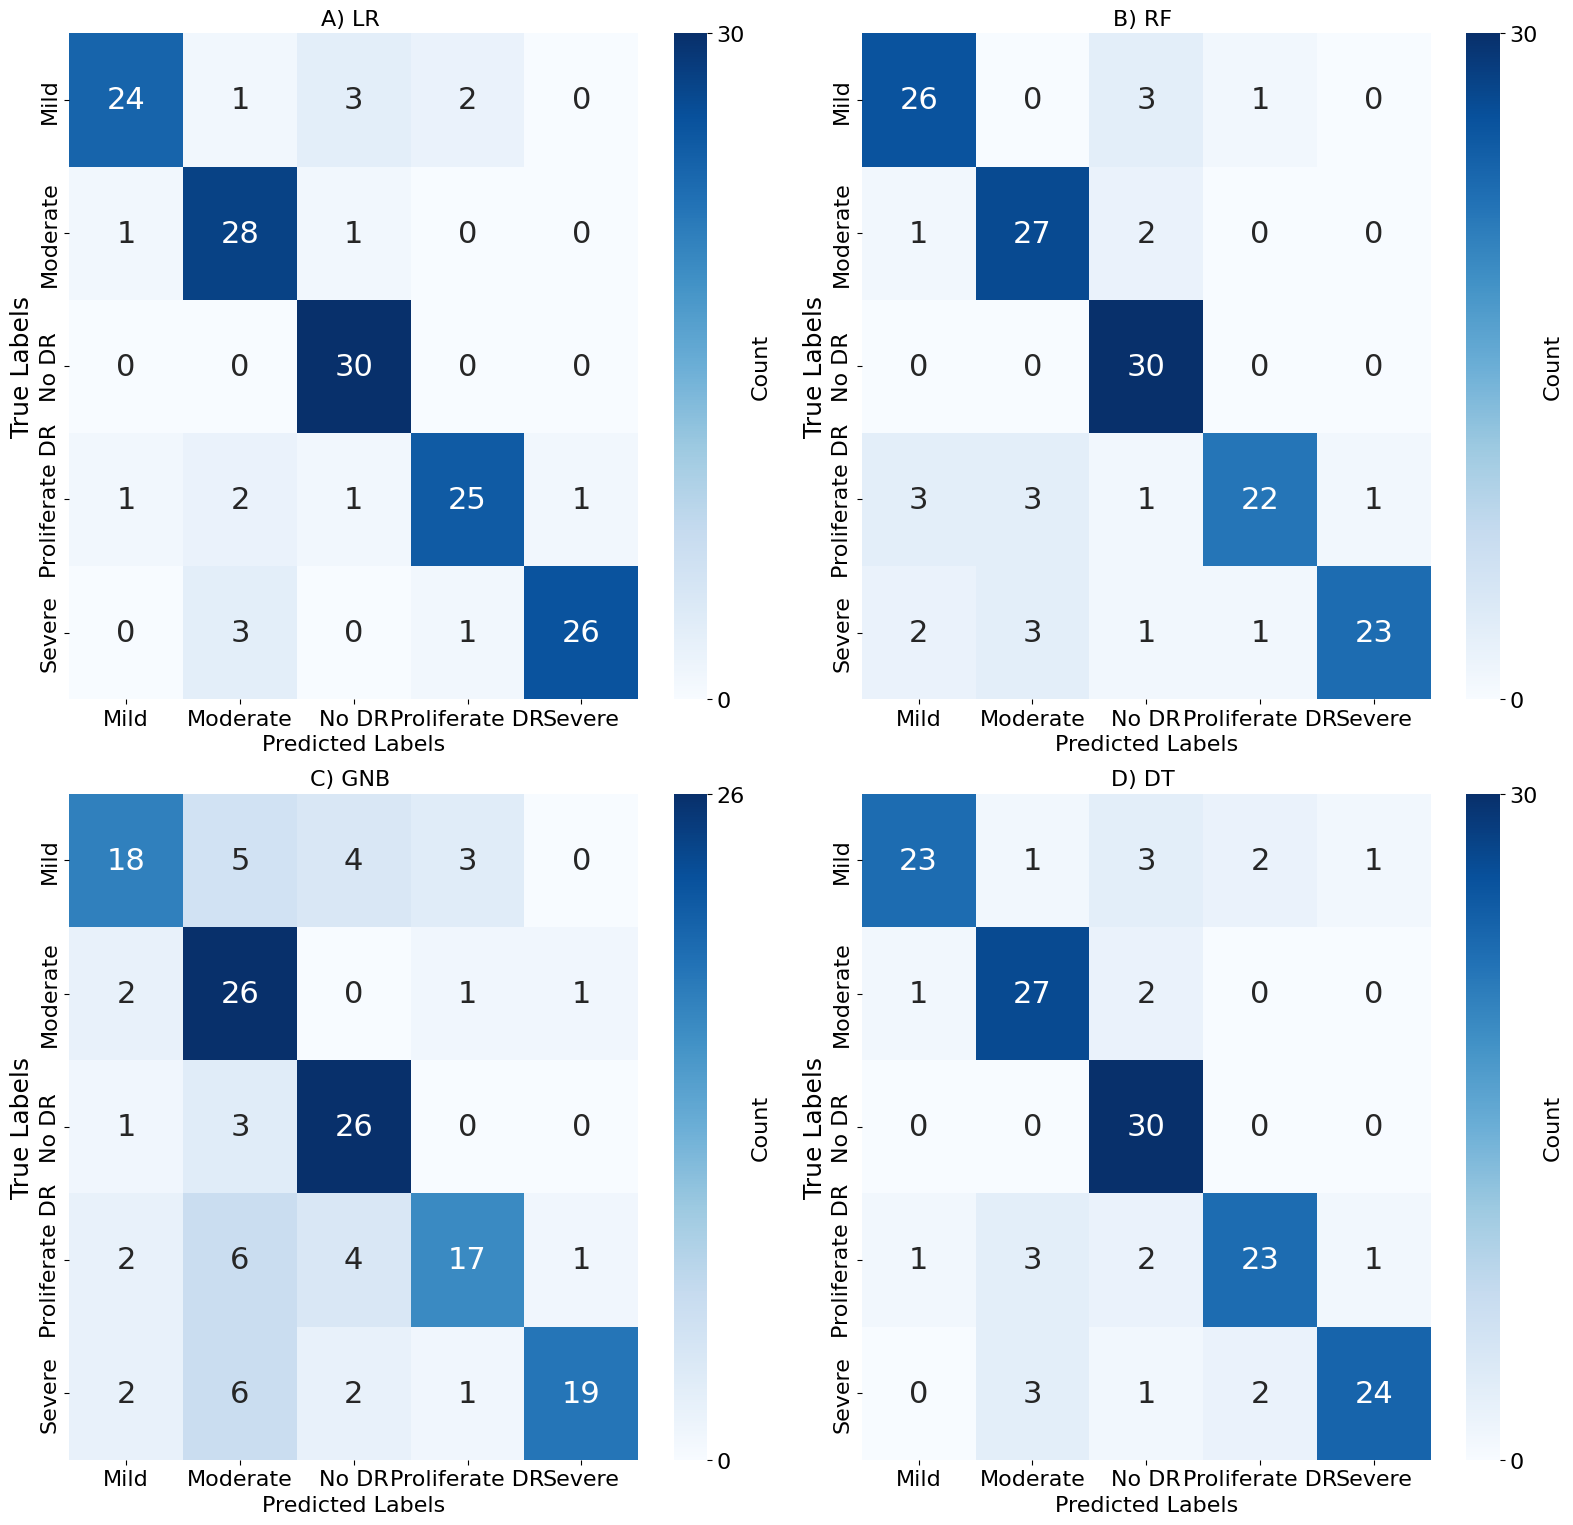

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrices
cm_lr = confusion_matrix(y_test, y_test_pred_cnn_lr)
cm_rf = confusion_matrix(y_test, y_test_pred_cnn_rfr)
cm_gnb = confusion_matrix(y_test, y_test_pred_cnn_gnb)
cm_dt = confusion_matrix(y_test, y_test_pred_cnn_dtr)

# Create the plot with 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

# List of models and corresponding confusion matrices
models = ['A) LR ', 'B) RF ', 'C) GNB ', 'D) DT ']
cms = [cm_lr, cm_rf, cm_gnb, cm_dt]

# Class names for the axes
class_names = ['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']
tick_positions = np.arange(len(class_names)) + 0.5  # Centering ticks

for i, ax in enumerate(axs.flat):
    # Create heatmap for each confusion matrix
    sns.heatmap(cms[i], annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Count', 'ticks': [0, cms[i].max()]}, ax=ax)

    # Set labels, ticks, and titles
    ax.set_xlabel('Predicted Labels', fontsize=16)
    ax.set_ylabel('True Labels', fontsize=18)
    ax.set_title(models[i], fontsize=16)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(class_names, fontsize=16)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(class_names, fontsize=16, rotation=90)
    ax.collections[0].colorbar.ax.tick_params(labelsize=16)
    ax.collections[0].colorbar.ax.set_ylabel('Count', fontsize=16)
    # Update font size for annotations
    for text in ax.texts:
        text.set_size(22)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # To prevent overlap with the title

plt.savefig('cm_cnn.png', dpi=300, bbox_inches='tight')  # Save the plot
plt.show()

from google.colab import files
files.download('cm_cnn.png')



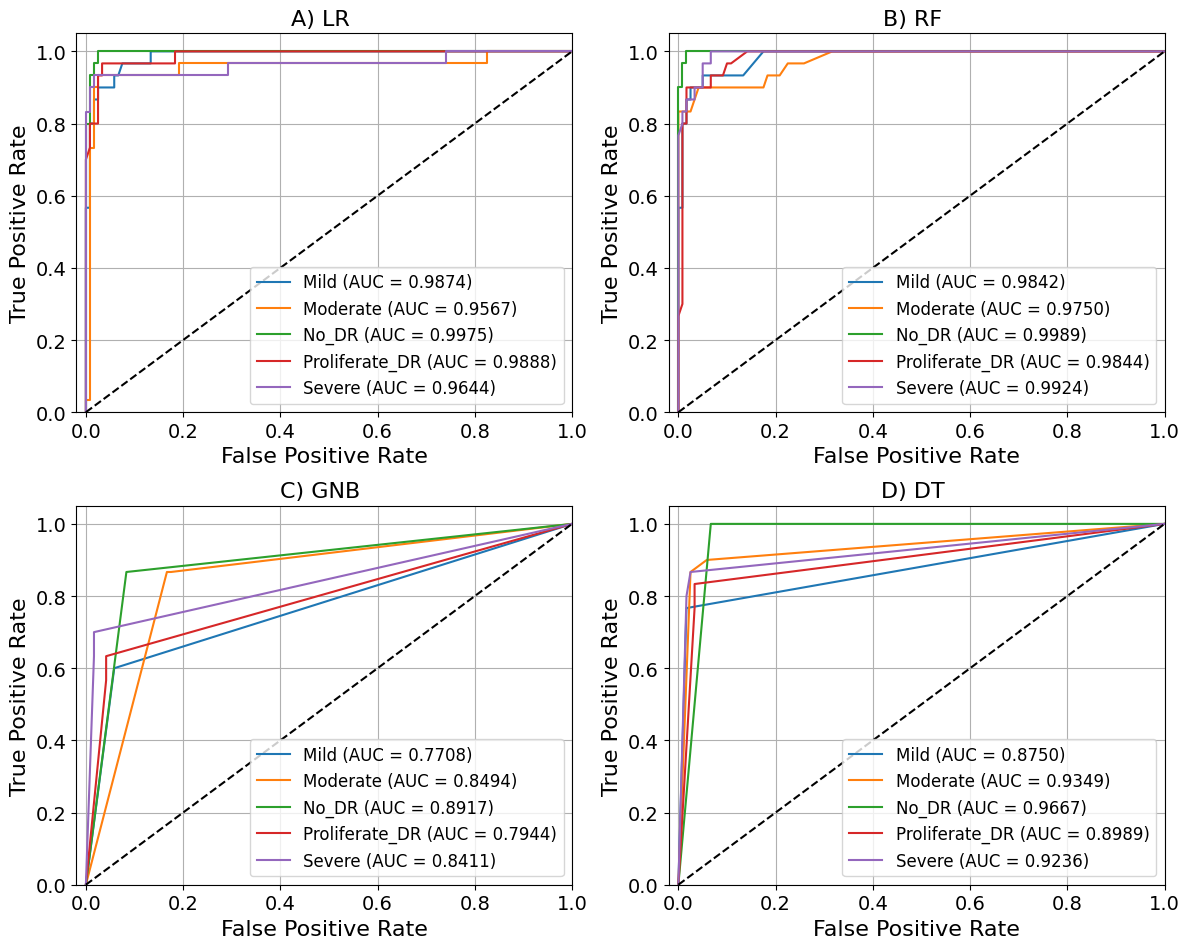

<Figure size 640x480 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

# Assuming you have already trained your models: logreg (LR), rfr (RF), gnb (GNB), dtr (DT)

# Predictions for each model
y_score_lr = logreg_cnn.predict_proba(cnn_features_test.reshape(cnn_features_test.shape[0], -1))
y_score_rf = rfr_cnn.predict_proba(cnn_features_test.reshape(cnn_features_test.shape[0], -1))
y_score_gnb = gnb_cnn.predict_proba(cnn_features_test.reshape(cnn_features_test.shape[0], -1))
y_score_dt = dtr_cnn.predict_proba(cnn_features_test.reshape(cnn_features_test.shape[0], -1))

# Binarize the labels for ROC curve
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Compute ROC curve and ROC area for each model
fpr_lr, tpr_lr, roc_auc_lr = dict(), dict(), dict()
fpr_rf, tpr_rf, roc_auc_rf = dict(), dict(), dict()
fpr_gnb, tpr_gnb, roc_auc_gnb = dict(), dict(), dict()
fpr_dt, tpr_dt, roc_auc_dt = dict(), dict(), dict()

n_classes = len(lb.classes_)

for i in range(n_classes):
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test_bin[:, i], y_score_lr[:, i])
    roc_auc_lr[i] = auc(fpr_lr[i], tpr_lr[i])

    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

    fpr_gnb[i], tpr_gnb[i], _ = roc_curve(y_test_bin[:, i], y_score_gnb[:, i])
    roc_auc_gnb[i] = auc(fpr_gnb[i], tpr_gnb[i])

    fpr_dt[i], tpr_dt[i], _ = roc_curve(y_test_bin[:, i], y_score_dt[:, i])
    roc_auc_dt[i] = auc(fpr_dt[i], tpr_dt[i])

# Plot ROC curves for each model in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# List of model names and corresponding ROC values
models = ['A) LR ', 'B) RF ', 'C) GNB ', 'D) DT ']
fprs = [fpr_lr, fpr_rf, fpr_gnb, fpr_dt]
tprs = [tpr_lr, tpr_rf, tpr_gnb, tpr_dt]
roc_aucs = [roc_auc_lr, roc_auc_rf, roc_auc_gnb, roc_auc_dt]

for i, ax in enumerate(axs.flat):
    # Plot the ROC curve for each class in the current model
    for j in range(n_classes):
        ax.plot(fprs[i][j], tprs[i][j], label=f'{lb.classes_[j]} (AUC = {roc_aucs[i][j]:.4f})')

    # Add random guessing line (diagonal)
    ax.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    ax.set_xlim([-0.02, 1.0])  # Set limit of X ticks
    ax.set_ylim([0.0, 1.05])  # Set limit of Y ticks
    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('True Positive Rate', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True)
    ax.set_title(models[i], fontsize=16)
    ax.grid(True)
    ax.legend(loc="lower right", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()

plt.savefig('roc_cnn.png', dpi=300, bbox_inches='tight')  # Save the plot
plt.show()

from google.colab import files
files.download('roc_cnn.png')

GLCM Features

In [ ]:
# Split training data: 90% for training, 10% discarded
# Extract GLCM features
import cv2
import numpy as np
from tqdm import tqdm

# Load and preprocess images
def load_images_from_folder(folder):
    images = []
    labels = []
    for class_name in os.listdir(folder):
        class_folder = os.path.join(folder, class_name)
        for filename in tqdm(os.listdir(class_folder)):
            img = cv2.imread(os.path.join(class_folder, filename))
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Resize images to 224x224
                images.append(img)
                labels.append(class_name)
    return np.array(images), np.array(labels)

# Load train, validation, and test datasets
X_train, y_train = load_images_from_folder(train_path)

X_test, y_test = load_images_from_folder(test_path)

def extract_glcm_features(images):
    glcm_features = []
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Updated function names from greycomatrix/greycoprops to graycomatrix/graycoprops
        glcm = graycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        glcm_features.append([contrast, homogeneity])
    return np.array(glcm_features)

glcm_features_train = extract_glcm_features(X_train)

glcm_features_test = extract_glcm_features(X_test)

glcm_features_train_glcm, _, y_train_glcm, _ = train_test_split(
    glcm_features_train, y_train, test_size=0.15, random_state=42
)

100%|██████████| 30/30 [00:00<00:00, 62.94it/s]


RF with GLCM

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# Train model using only 90% of GLCM features
rfr_glcm = RandomForestClassifier(n_estimators=100, random_state=42)
rfr_glcm.fit(glcm_features_train_glcm, y_train_glcm)

# Evaluate model on test set using GLCM features
y_test_pred_glcm_rfr = rfr_glcm.predict(glcm_features_test)

print("Test Set Evaluation (GLCM Features Only, 90% Training Data):")
print(classification_report(y_test, y_test_pred_glcm_rfr, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))



Test Set Evaluation (GLCM Features Only, 90% Training Data):
                precision    recall  f1-score   support

          Mild       0.93      0.87      0.90        30
      Moderate       0.94      0.97      0.95        30
         No DR       0.91      1.00      0.95        30
Proliferate DR       0.87      0.90      0.89        30
        Severe       1.00      0.90      0.95        30

      accuracy                           0.93       150
     macro avg       0.93      0.93      0.93       150
  weighted avg       0.93      0.93      0.93       150



GNB with GLCM

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# Train Gaussian Naive Bayes (GNB) model using only 20% of GLCM features
gnb_glcm = GaussianNB()
gnb_glcm.fit(glcm_features_train_glcm, y_train_glcm)

# Evaluate model on test set using GLCM features
y_test_pred_glcm_gnb = gnb_glcm.predict(glcm_features_test)

print("Test Set Evaluation (GLCM Features Only, 20% Training Data):")
print(classification_report(y_test, y_test_pred_glcm_gnb, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))

Test Set Evaluation (GLCM Features Only, 20% Training Data):
                precision    recall  f1-score   support

          Mild       0.00      0.00      0.00        30
      Moderate       0.50      0.23      0.32        30
         No DR       0.25      1.00      0.39        30
Proliferate DR       0.00      0.00      0.00        30
        Severe       0.50      0.10      0.17        30

      accuracy                           0.27       150
     macro avg       0.25      0.27      0.18       150
  weighted avg       0.25      0.27      0.18       150



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


DTR with GLCM

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Train Decision Tree model
dtr_glcm = DecisionTreeClassifier(random_state=42)
dtr_glcm.fit(glcm_features_train_glcm, y_train_glcm)

# Evaluate model on test set
y_test_pred_glcm_dtr = dtr_glcm.predict(glcm_features_test)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred_glcm_dtr, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))

Test Set Evaluation:
                precision    recall  f1-score   support

          Mild       0.93      0.87      0.90        30
      Moderate       0.85      0.93      0.89        30
         No DR       0.85      0.93      0.89        30
Proliferate DR       0.87      0.87      0.87        30
        Severe       1.00      0.87      0.93        30

      accuracy                           0.89       150
     macro avg       0.90      0.89      0.89       150
  weighted avg       0.90      0.89      0.89       150



LR with GLCM

In [ ]:
# Split training data: 20% for training, 80% discarded
glcm_features_train_20, _, y_train_20, _ = train_test_split(
    glcm_features_train, y_train, test_size=0.15, random_state=42
)

# Train Logistic Regression model using only 20% of GLCM features
logreg_glcm = LogisticRegression(max_iter=500, random_state=42, multi_class='multinomial')
logreg_glcm.fit(glcm_features_train_glcm, y_train_glcm)

# Evaluate model on test set using GLCM features
y_test_pred_glcm_logreg = logreg_glcm.predict(glcm_features_test)

print("Test Set Evaluation (GLCM Features Only, 20% Training Data):")
print(classification_report(y_test, y_test_pred_glcm_logreg, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Set Evaluation (GLCM Features Only, 20% Training Data):
                precision    recall  f1-score   support

          Mild       0.29      0.07      0.11        30
      Moderate       0.00      0.00      0.00        30
         No DR       0.21      1.00      0.35        30
Proliferate DR       0.00      0.00      0.00        30
        Severe       0.00      0.00      0.00        30

      accuracy                           0.21       150
     macro avg       0.10      0.21      0.09       150
  weighted avg       0.10      0.21      0.09       150



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

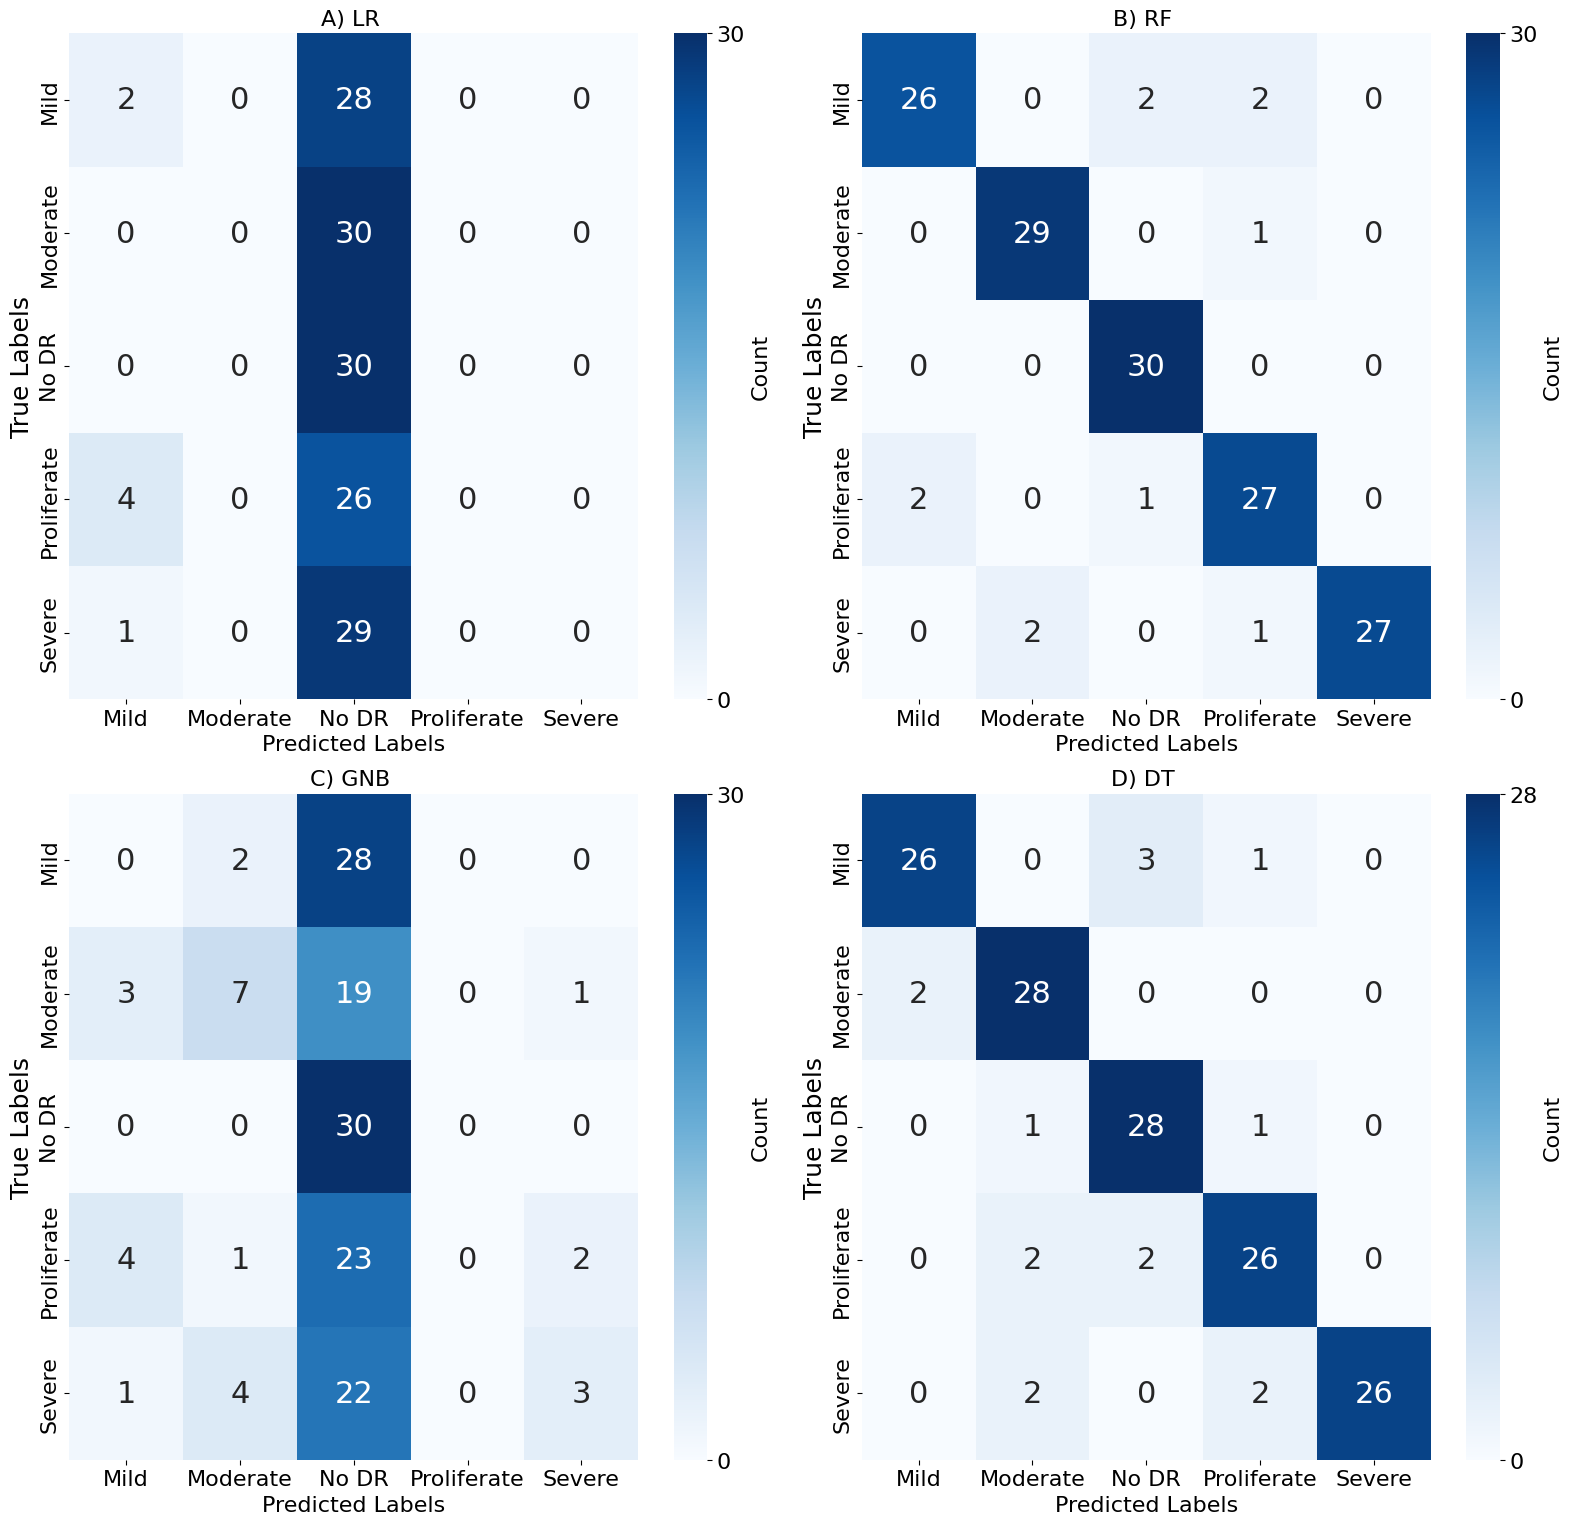

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrices
cm_lr = confusion_matrix(y_test, y_test_pred_glcm_logreg)
cm_rf = confusion_matrix(y_test, y_test_pred_glcm_rfr)
cm_gnb = confusion_matrix(y_test, y_test_pred_glcm_gnb)
cm_dt = confusion_matrix(y_test, y_test_pred_glcm_dtr)

# Create the plot with 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

# List of models and corresponding confusion matrices
models = ['A) LR ', 'B) RF ', 'C) GNB ', 'D) DT ']
cms = [cm_lr, cm_rf, cm_gnb, cm_dt]

# Class names for the axes
class_names = ['Mild', 'Moderate', 'No DR', 'Proliferate', 'Severe']
tick_positions = np.arange(len(class_names)) + 0.5  # Centering ticks

for i, ax in enumerate(axs.flat):
    # Create heatmap for each confusion matrix
    sns.heatmap(cms[i], annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Count', 'ticks': [0, cms[i].max()]}, ax=ax)

    # Set labels, ticks, and titles
    ax.set_xlabel('Predicted Labels', fontsize=16)
    ax.set_ylabel('True Labels', fontsize=18)
    ax.set_title(models[i], fontsize=16)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(class_names, fontsize=16)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(class_names, fontsize=16, rotation=90)
    ax.collections[0].colorbar.ax.tick_params(labelsize=16)
    ax.collections[0].colorbar.ax.set_ylabel('Count', fontsize=16)
    # Update font size for annotations
    for text in ax.texts:
        text.set_size(22)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # To prevent overlap with the title
plt.show()

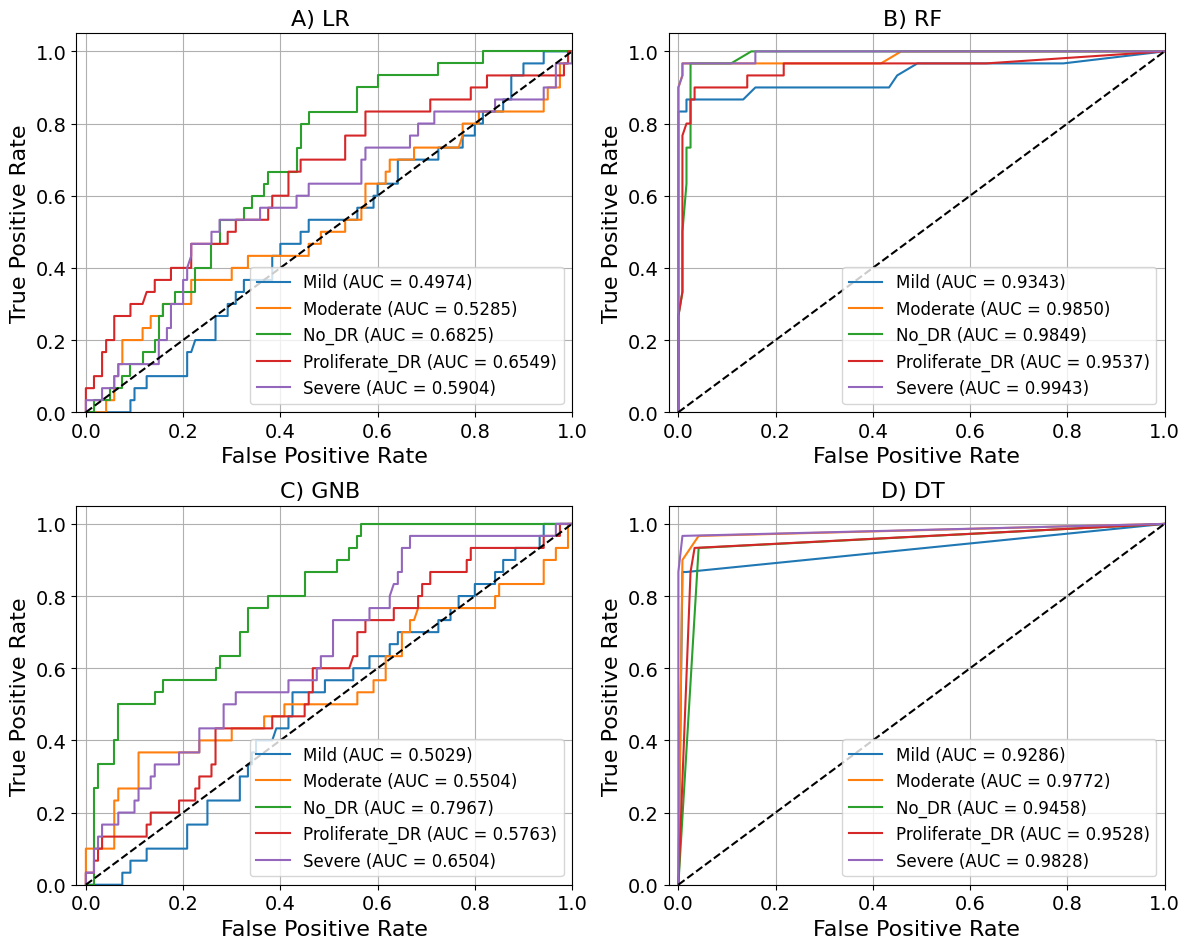

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

# Assuming you have already trained your models: logreg (LR), rfr (RF), gnb (GNB), dtr (DT)

# Predictions for each model
y_score_lr = logreg_glcm.predict_proba(glcm_features_test)
y_score_rf = rfr_glcm.predict_proba(glcm_features_test)
y_score_gnb = gnb_glcm.predict_proba(glcm_features_test)
y_score_dt = dtr_glcm.predict_proba(glcm_features_test)

# Binarize the labels for ROC curve
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Compute ROC curve and ROC area for each model
fpr_lr, tpr_lr, roc_auc_lr = dict(), dict(), dict()
fpr_rf, tpr_rf, roc_auc_rf = dict(), dict(), dict()
fpr_gnb, tpr_gnb, roc_auc_gnb = dict(), dict(), dict()
fpr_dt, tpr_dt, roc_auc_dt = dict(), dict(), dict()

n_classes = len(lb.classes_)

for i in range(n_classes):
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test_bin[:, i], y_score_lr[:, i])
    roc_auc_lr[i] = auc(fpr_lr[i], tpr_lr[i])

    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

    fpr_gnb[i], tpr_gnb[i], _ = roc_curve(y_test_bin[:, i], y_score_gnb[:, i])
    roc_auc_gnb[i] = auc(fpr_gnb[i], tpr_gnb[i])

    fpr_dt[i], tpr_dt[i], _ = roc_curve(y_test_bin[:, i], y_score_dt[:, i])
    roc_auc_dt[i] = auc(fpr_dt[i], tpr_dt[i])

# Plot ROC curves for each model in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# List of model names and corresponding ROC values
models = ['A) LR ', 'B) RF ', 'C) GNB ', 'D) DT ']
fprs = [fpr_lr, fpr_rf, fpr_gnb, fpr_dt]
tprs = [tpr_lr, tpr_rf, tpr_gnb, tpr_dt]
roc_aucs = [roc_auc_lr, roc_auc_rf, roc_auc_gnb, roc_auc_dt]

for i, ax in enumerate(axs.flat):
    # Plot the ROC curve for each class in the current model
    for j in range(n_classes):
        ax.plot(fprs[i][j], tprs[i][j], label=f'{lb.classes_[j]} (AUC = {roc_aucs[i][j]:.4f})')

    # Add random guessing line (diagonal)
    ax.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    ax.set_xlim([-0.02, 1.0])  # Set limit of X ticks
    ax.set_ylim([0.0, 1.05])  # Set limit of Y ticks
    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('True Positive Rate', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True)
    ax.set_title(models[i], fontsize=16)
    ax.grid(True)
    ax.legend(loc="lower right", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()


COMBINE Features

In [ ]:
base_path = '/content/drive/My Drive/Diabetic_Retino/PreProcessed/'

In [ ]:
import os

# Define paths to train, validation, and test datasets
base_path = '/content/drive/My Drive/Diabetetic_Retino/preprocced/'
train_path = os.path.join(base_path, 'train')

test_path = os.path.join(base_path, 'test')



import cv2
import numpy as np
from tqdm import tqdm

# Load and preprocess images
def load_images_from_folder(folder):
    images = []
    labels = []
    for class_name in os.listdir(folder):
        class_folder = os.path.join(folder, class_name)
        for filename in tqdm(os.listdir(class_folder)):
            img = cv2.imread(os.path.join(class_folder, filename))
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Resize images to 224x224
                images.append(img)
                labels.append(class_name)
    return np.array(images), np.array(labels)

# Load train, validation, and test datasets
X_train, y_train = load_images_from_folder(train_path)

X_test, y_test = load_images_from_folder(test_path)


100%|██████████| 30/30 [00:00<00:00, 116.92it/s]


In [ ]:
from tensorflow.keras.applications import VGG16
# Updated import statement
from skimage.feature import graycomatrix, graycoprops
import cv2
import numpy as np
from tqdm import tqdm

# Extract CNN features
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
cnn_features_train = base_model.predict(X_train)

cnn_features_test = base_model.predict(X_test)

# Extract GLCM features
def extract_glcm_features(images):
    glcm_features = []
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Updated function names from greycomatrix/greycoprops to graycomatrix/graycoprops
        glcm = graycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        glcm_features.append([contrast, homogeneity])
    return np.array(glcm_features)

glcm_features_train = extract_glcm_features(X_train)

glcm_features_test = extract_glcm_features(X_test)


153/153 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


In [ ]:
# Combine CNN and GLCM features
def combine_features(cnn_features, glcm_features):
    return np.concatenate((cnn_features.reshape(cnn_features.shape[0], -1), glcm_features), axis=1)

X_train_combined = combine_features(cnn_features_train, glcm_features_train)

X_test_combined = combine_features(cnn_features_test, glcm_features_test)

# Train model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rfr_com = RandomForestClassifier(n_estimators=100, random_state=42)
rfr_com.fit(X_train_combined, y_train)



# Evaluate model on test set
y_test_pred = rfr.predict(X_test_combined)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=['Mild', 'Moderate', 'No DR', 'Proleferate DR', 'Severe']))



Test Set Evaluation:
                precision    recall  f1-score   support

          Mild       0.94      1.00      0.97        30
      Moderate       0.94      0.97      0.95        30
         No DR       1.00      1.00      1.00        30
Proleferate DR       1.00      0.97      0.98        30
        Severe       1.00      0.93      0.97        30

      accuracy                           0.97       150
     macro avg       0.97      0.97      0.97       150
  weighted avg       0.97      0.97      0.97       150



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Train Decision Tree model
dtr_com = DecisionTreeClassifier(random_state=42)
dtr_com.fit(X_train_combined, y_train)

# Evaluate model on test set
y_test_pred = dtr_com.predict(X_test_combined)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))


Test Set Evaluation:
                precision    recall  f1-score   support

          Mild       0.94      1.00      0.97        30
      Moderate       0.88      0.97      0.92        30
         No DR       1.00      1.00      1.00        30
Proliferate DR       1.00      0.90      0.95        30
        Severe       1.00      0.93      0.97        30

      accuracy                           0.96       150
     macro avg       0.96      0.96      0.96       150
  weighted avg       0.96      0.96      0.96       150



In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

# Train Gaussian Naive Bayes (GNB) model
gnb_com = GaussianNB()
gnb_com.fit(X_train_combined, y_train)

# Evaluate model on test set
y_test_pred = gnb_com.predict(X_test_combined)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))



Test Set Evaluation:
                precision    recall  f1-score   support

          Mild       0.71      0.67      0.69        30
      Moderate       0.57      1.00      0.72        30
         No DR       0.87      0.87      0.87        30
Proliferate DR       1.00      0.57      0.72        30
        Severe       0.95      0.70      0.81        30

      accuracy                           0.76       150
     macro avg       0.82      0.76      0.76       150
  weighted avg       0.82      0.76      0.76       150



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train Logistic Regression Classifier
logreg_com = LogisticRegression(max_iter=500, random_state=42, multi_class='multinomial')
logreg_com.fit(X_train_combined, y_train)

# Evaluate model on test set
y_test_pred = logreg_com.predict(X_test_combined)
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Set Evaluation:
                precision    recall  f1-score   support

          Mild       0.97      1.00      0.98        30
      Moderate       0.97      0.97      0.97        30
         No DR       1.00      1.00      1.00        30
Proliferate DR       1.00      0.93      0.97        30
        Severe       0.97      1.00      0.98        30

      accuracy                           0.98       150
     macro avg       0.98      0.98      0.98       150
  weighted avg       0.98      0.98      0.98       150



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


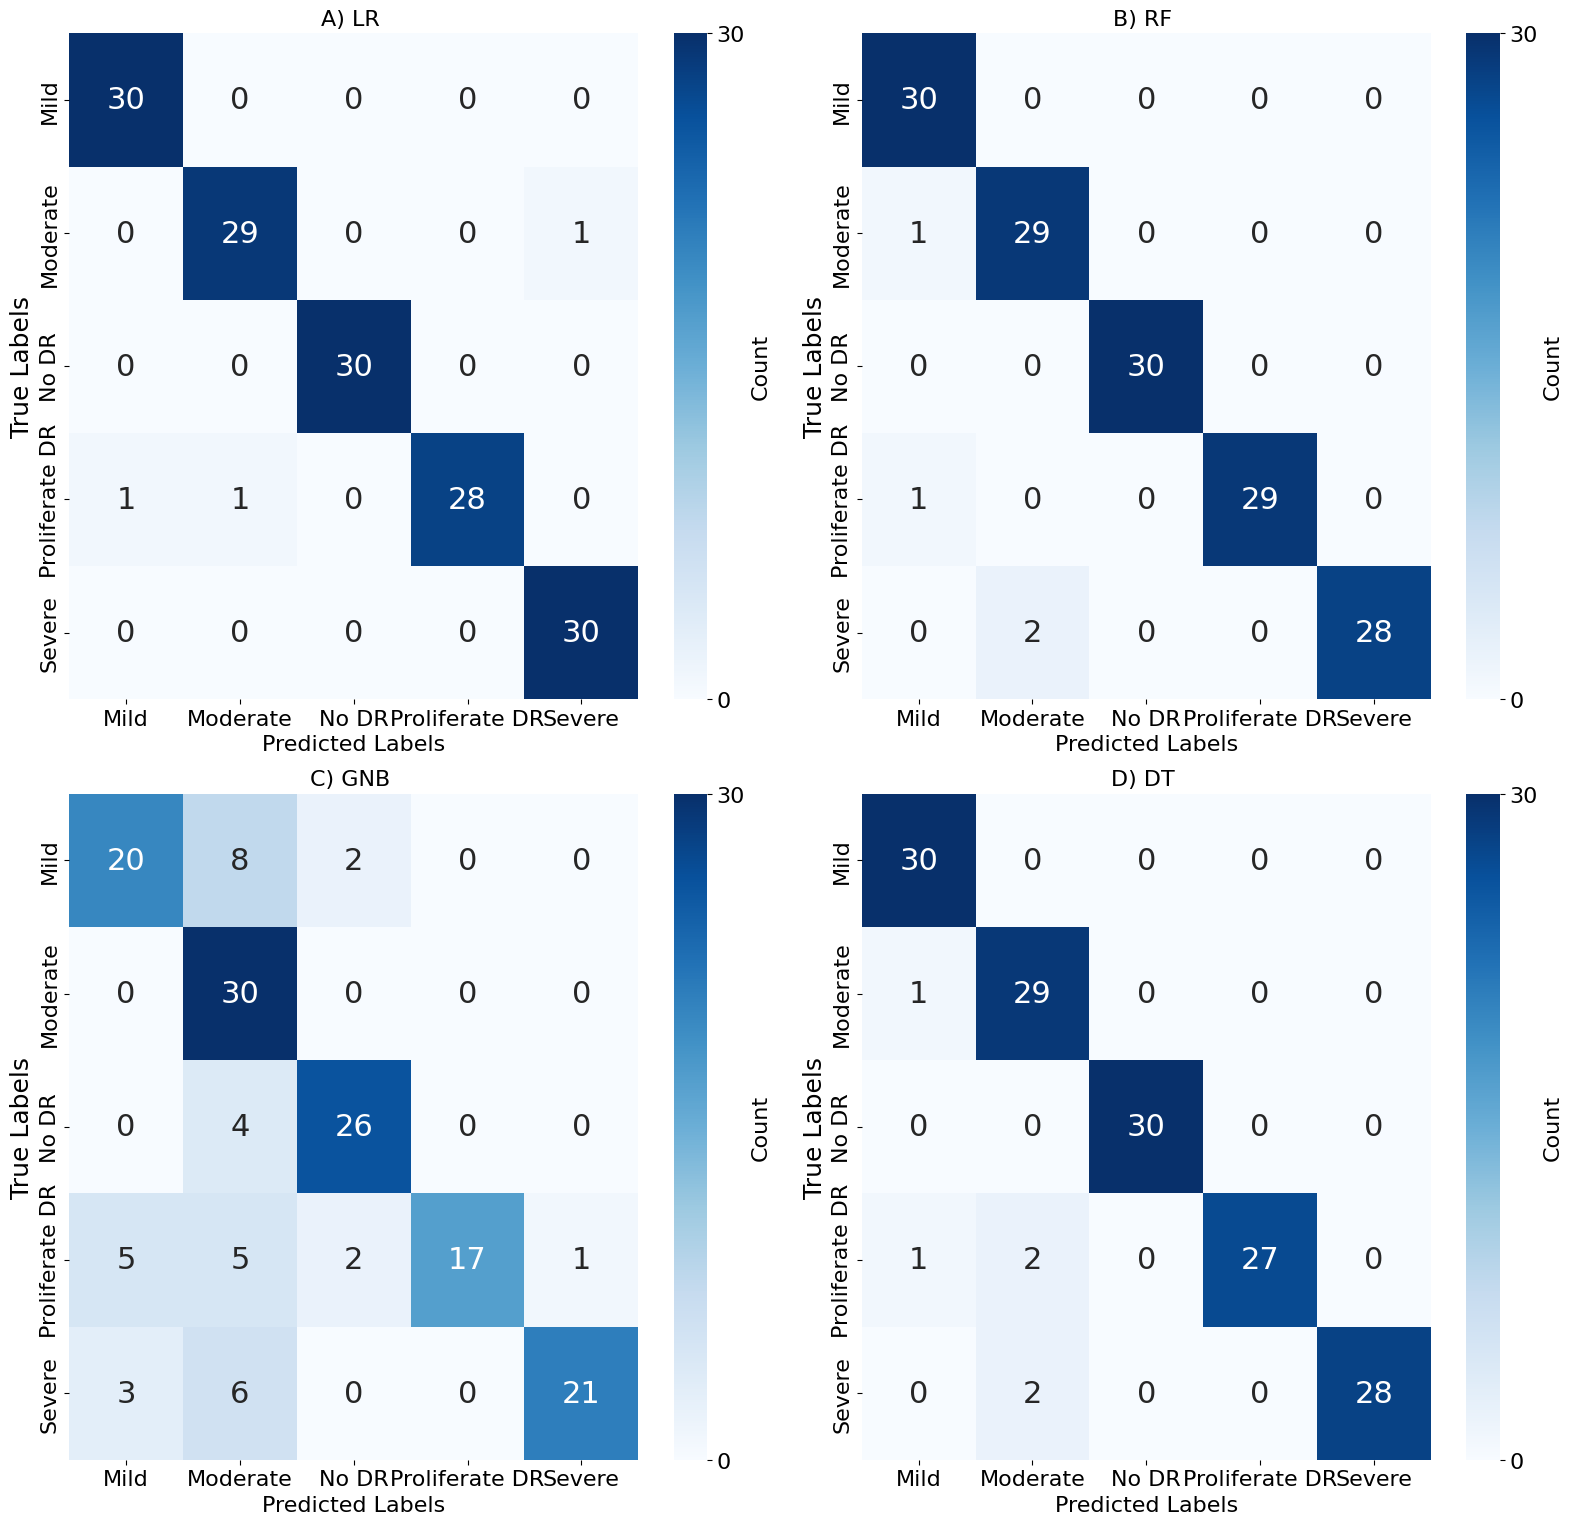

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Test data and predictions assumed to be available
# y_test = ...
# X_test_combined = ...
# Assuming trained classifiers: logreg (LR), rfr (RF), gnb (GNB), dtr (DT)

# Predictions for each model
y_test_pred_lr = logreg_com.predict(X_test_combined)
y_test_pred_rf = rfr_com.predict(X_test_combined)
y_test_pred_gnb = gnb_com.predict(X_test_combined)
y_test_pred_dt = dtr_com.predict(X_test_combined)

# Confusion matrices for each model
cm_lr = confusion_matrix(y_test, y_test_pred_lr)
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
cm_gnb = confusion_matrix(y_test, y_test_pred_gnb)
cm_dt = confusion_matrix(y_test, y_test_pred_dt)

# Create the plot with 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

# List of models and corresponding confusion matrices
models = ['A) LR ', 'B) RF ', 'C) GNB ', 'D) DT ']
cms = [cm_lr, cm_rf, cm_gnb, cm_dt]

# Class names for the axes
class_names = ['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']
tick_positions = np.arange(len(class_names)) + 0.5  # Centering ticks

for i, ax in enumerate(axs.flat):
    # Create heatmap for each confusion matrix
    sns.heatmap(cms[i], annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Count', 'ticks': [0, cms[i].max()]}, ax=ax)

    # Set labels, ticks, and titles
    ax.set_xlabel('Predicted Labels', fontsize=16)
    ax.set_ylabel('True Labels', fontsize=18)
    ax.set_title(models[i], fontsize=16)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(class_names, fontsize=16)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(class_names, fontsize=16, rotation=90)
    ax.collections[0].colorbar.ax.tick_params(labelsize=16)
    ax.collections[0].colorbar.ax.set_ylabel('Count', fontsize=16)
    # Update font size for annotations
    for text in ax.texts:
        text.set_size(22)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # To prevent overlap with the title
plt.show()


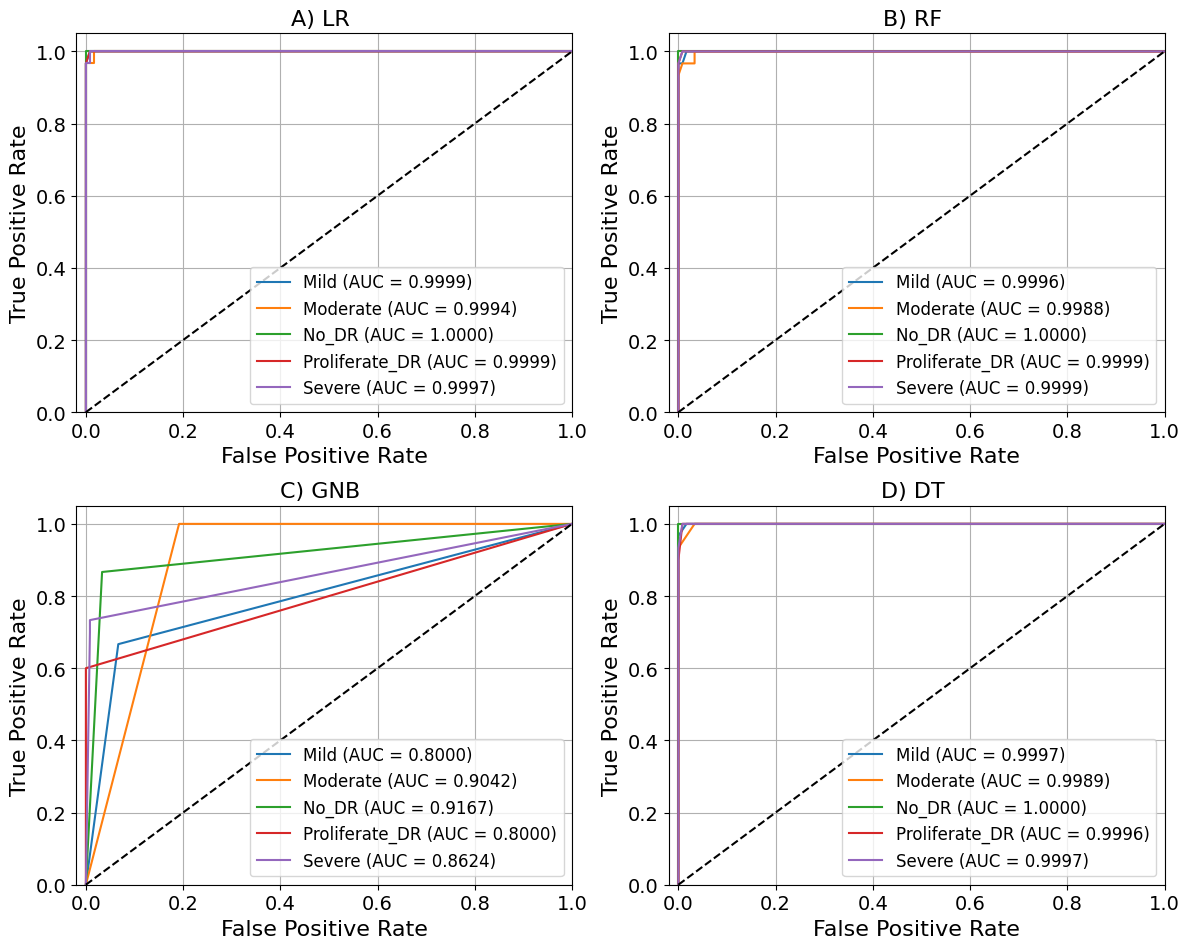

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

# Assuming you have already trained your models: logreg (LR), rfr (RF), gnb (GNB), dtr (DT)

# Predictions for each model
y_score_lr = logreg_com.predict_proba(X_test_combined)
y_score_rf = rfr_com.predict_proba(X_test_combined)
y_score_gnb = gnb_com.predict_proba(X_test_combined)
y_score_dt = dtr_com.predict_proba(X_test_combined)

# Binarize the labels for ROC curve
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Compute ROC curve and ROC area for each model
fpr_lr, tpr_lr, roc_auc_lr = dict(), dict(), dict()
fpr_rf, tpr_rf, roc_auc_rf = dict(), dict(), dict()
fpr_gnb, tpr_gnb, roc_auc_gnb = dict(), dict(), dict()
fpr_dt, tpr_dt, roc_auc_dt = dict(), dict(), dict()

n_classes = len(lb.classes_)

for i in range(n_classes):
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test_bin[:, i], y_score_lr[:, i])
    roc_auc_lr[i] = auc(fpr_lr[i], tpr_lr[i])

    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

    fpr_gnb[i], tpr_gnb[i], _ = roc_curve(y_test_bin[:, i], y_score_gnb[:, i])
    roc_auc_gnb[i] = auc(fpr_gnb[i], tpr_gnb[i])

    fpr_dt[i], tpr_dt[i], _ = roc_curve(y_test_bin[:, i], y_score_dt[:, i])
    roc_auc_dt[i] = auc(fpr_dt[i], tpr_dt[i])

# Plot ROC curves for each model in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# List of model names and corresponding ROC values
models = ['A) LR ', 'B) RF ', 'C) GNB ', 'D) DT ']
fprs = [fpr_lr, fpr_rf, fpr_gnb, fpr_dt]
tprs = [tpr_lr, tpr_rf, tpr_gnb, tpr_dt]
roc_aucs = [roc_auc_lr, roc_auc_rf, roc_auc_gnb, roc_auc_dt]

for i, ax in enumerate(axs.flat):
    # Plot the ROC curve for each class in the current model
    for j in range(n_classes):
        ax.plot(fprs[i][j], tprs[i][j], label=f'{lb.classes_[j]} (AUC = {roc_aucs[i][j]:.4f})')

    # Add random guessing line (diagonal)
    ax.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    ax.set_xlim([-0.02, 1.0])  # Set limit of X ticks
    ax.set_ylim([0.0, 1.05])  # Set limit of Y ticks
    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('True Positive Rate', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True)
    ax.set_title(models[i], fontsize=16)
    ax.grid(True)
    ax.legend(loc="lower right", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()


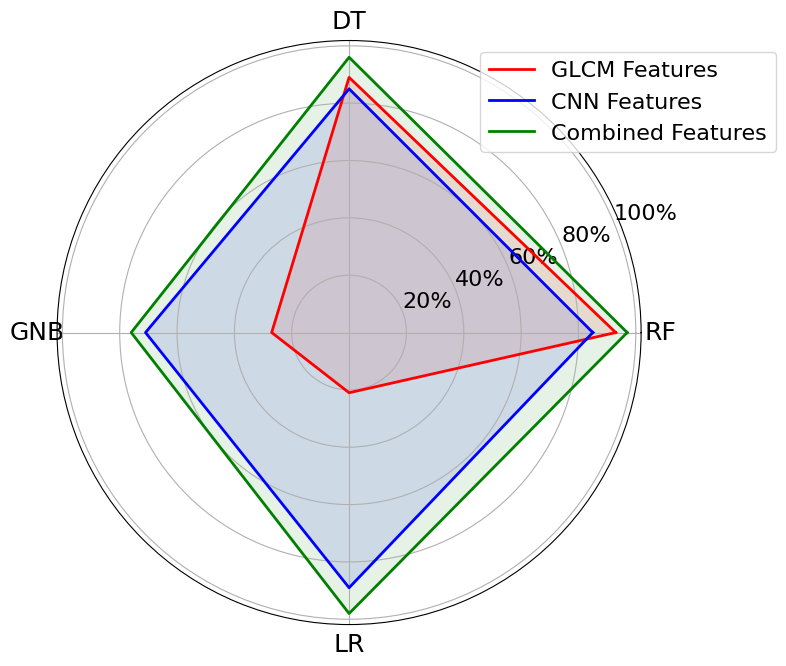

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the models and their accuracies for GLCM, CNN, and Combined features
models = ['RF', 'DT', 'GNB', 'LR']
accuracies_cnn = [85, 85, 71, 89]   # CNN feature set accuracies
# Accuracies for GLCM, CNN, and Combined features
accuracies_glcm = [93, 89, 27, 21]  # GLCM feature set accuracies

accuracies_combined = [97, 96, 76, 98]  # Combined feature set accuracies


# Number of variables (models)
num_vars = len(models)

# Compute angle for each model (equally spaced in the radar plot)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Ensure the plots are closed loops
accuracies_glcm += accuracies_glcm[:1]
accuracies_cnn += accuracies_cnn[:1]
accuracies_combined += accuracies_combined[:1]
angles += angles[:1]

# Initialize the radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot the data for each feature set
ax.plot(angles, accuracies_glcm, color='red', linewidth=2, label='GLCM Features')
ax.fill(angles, accuracies_glcm, color='red', alpha=0.1)

ax.plot(angles, accuracies_cnn, color='blue', linewidth=2, label='CNN Features')
ax.fill(angles, accuracies_cnn, color='blue', alpha=0.1)

ax.plot(angles, accuracies_combined, color='green', linewidth=2, label='Combined Features')
ax.fill(angles, accuracies_combined, color='green', alpha=0.1)

# Add labels for each model
ax.set_yticks([20, 40, 60, 80, 100])  # Define y-axis ticks
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=16)
ax.set_xticks(angles[:-1])  # Skip the last angle (repeated)
ax.set_xticklabels(models, fontsize=18)

# Add title and legend
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.0), fontsize=16)

# Grid customization
ax.grid(True)

# Save the plot as a high-resolution PNG file (300 DPI)
plt.tight_layout()
plt.savefig('accu_plot.png', dpi=300, bbox_inches='tight')  # Save the plot
plt.show()

In [ ]:
plt.tight_layout()
plt.savefig('accu_plot.png', dpi=300, bbox_inches='tight')  # Save the plot
plt.show()

from google.colab import files
files.download('accu_plot.png')

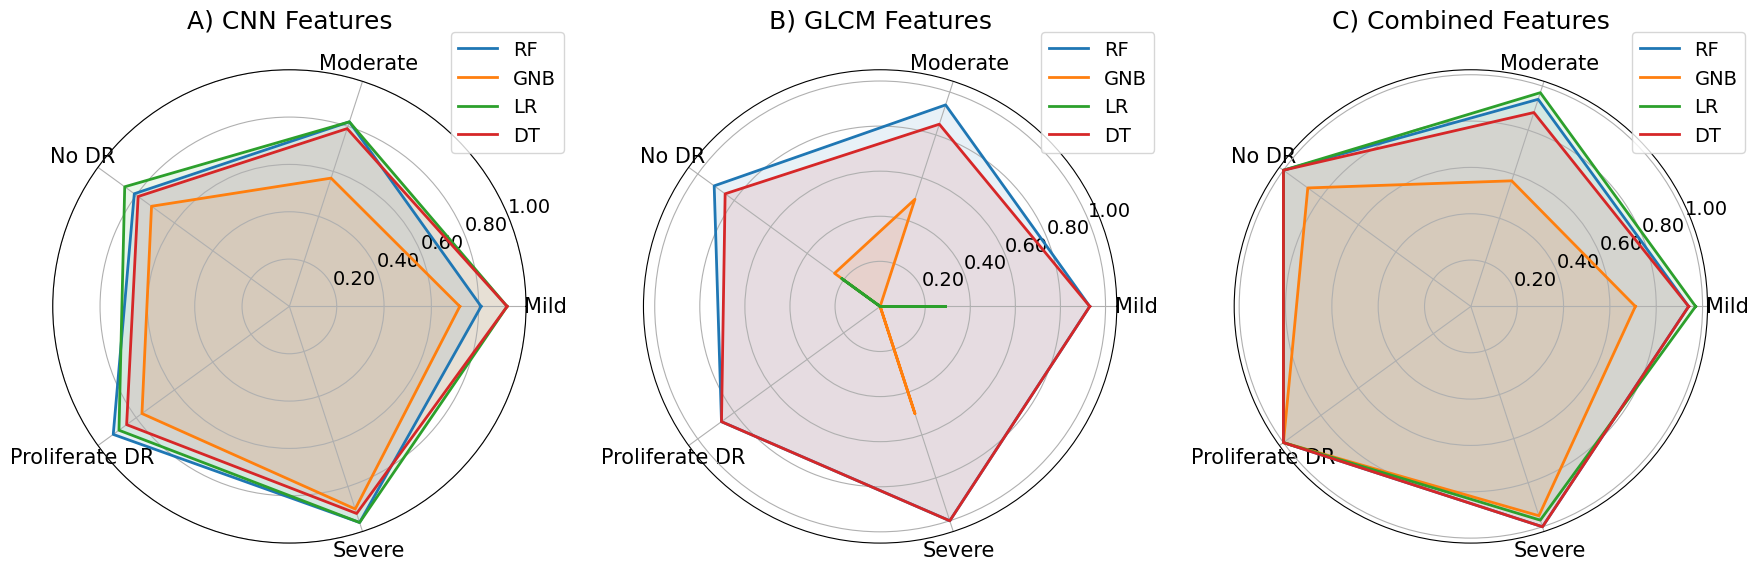

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Models and class labels
models = ['RF', 'GNB', 'LR', 'DT']
class_labels = ['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']
num_vars = len(class_labels)

# Precision values for each model and feature set
precision_values = {
    'CNN Features': {
        'RF': [0.81, 0.82, 0.81, 0.92, 0.96],
        'GNB': [0.72, 0.57, 0.72, 0.77, 0.90],
        'LR': [0.92, 0.82, 0.86, 0.89, 0.96],
        'DT': [0.92, 0.79, 0.79, 0.85, 0.92]
    },
    'GLCM Features': {
        'RF': [0.93, 0.94, 0.91, 0.87, 1.00],
        'GNB': [0.00, 0.50, 0.25, 0.00, 0.50],
        'LR': [0.29, 0.00, 0.21, 0.00, 0.00],
        'DT': [0.93, 0.85, 0.85, 0.87, 1.00]
    },
    'Combined Features': {
        'RF': [0.94, 0.94, 1.00, 1.00, 1.00],
        'GNB': [0.71, 0.57, 0.87, 1.00, 0.95],
        'LR': [0.97, 0.97, 1.00, 1.00, 0.97],
        'DT': [0.94, 0.88, 1.00, 1.00, 1.00]
    }
}

# Compute angles for radar chart (one per class)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 8), subplot_kw=dict(polar=True))

# Generate radar chart for each feature set
for i, feature_set in enumerate(['CNN Features', 'GLCM Features', 'Combined Features']):
    ax = axes[i]

    for model, precision in precision_values[feature_set].items():
        precision_looped = precision + precision[:1]  # close the loop
        ax.plot(angles, precision_looped, label=model, linewidth=2)
        ax.fill(angles, precision_looped, alpha=0.1)

    # Customize axis
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.20', '0.40', '0.60', '0.80', '1.00'], fontsize=14)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(class_labels, fontsize=15)
    ax.set_title(f'{chr(65+i)}) {feature_set}', fontsize=18, pad=30)

    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize=14)

# Final layout adjustments
plt.tight_layout(pad=2.0)
plt.savefig('precision_plot.png', dpi=300, bbox_inches='tight')
plt.show()


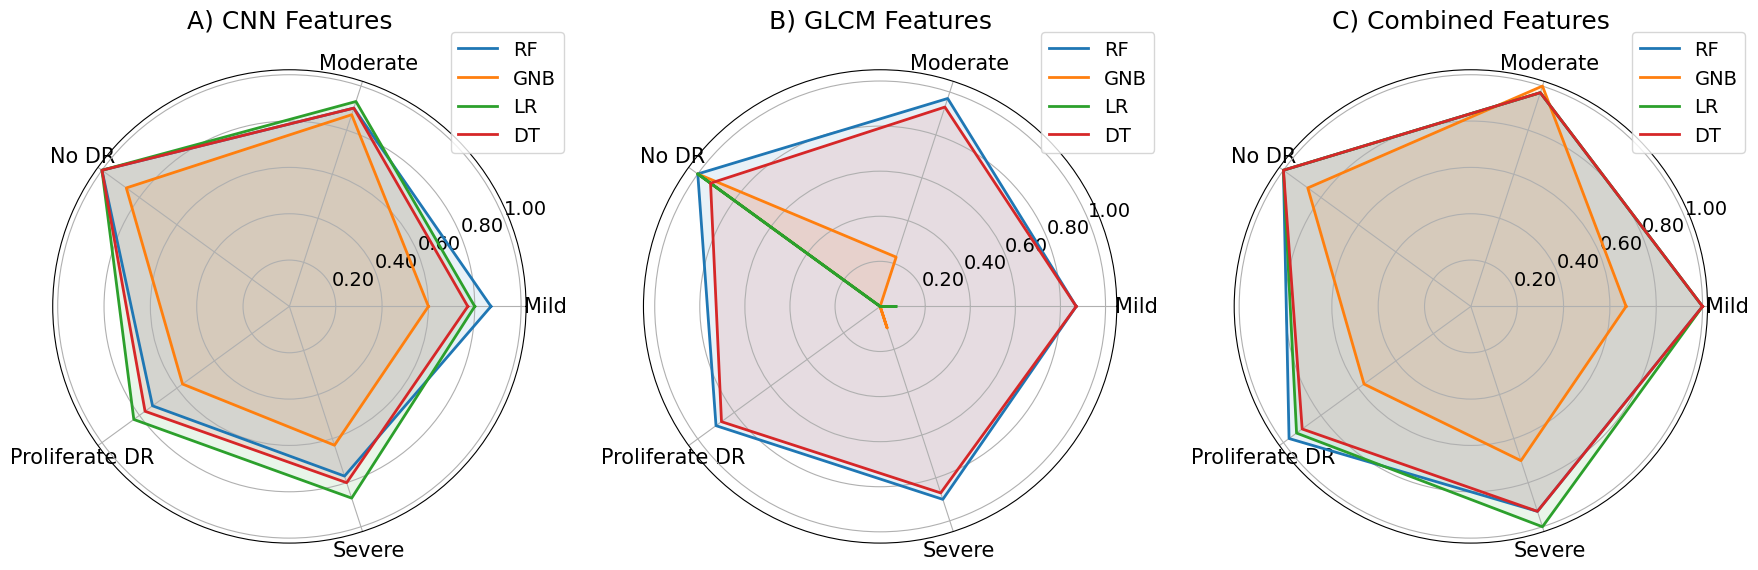

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example recall data for models (replace with actual recall values)
models = ['RF', 'GNB', 'LR', 'DT']
class_labels = ['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']
num_vars = len(class_labels)

# Recall values for each model and feature set
recall_values = {
    'CNN Features': {
        'RF': [0.87, 0.90, 1.00, 0.73, 0.77],
        'GNB': [0.60, 0.87, 0.87, 0.57, 0.63],
        'LR': [0.80, 0.93, 1.00, 0.83, 0.87],
        'DT': [0.77, 0.90, 1.00, 0.77, 0.80]
    },
    'GLCM Features': {
        'RF': [0.87, 0.97, 1.00, 0.90, 0.90],
        'GNB': [0.00, 0.23, 1.00, 0.00, 0.10],
        'LR': [0.07, 0.00, 1.00, 0.00, 0.00],
        'DT': [0.87, 0.93, 0.93, 0.87, 0.87]
    },
    'Combined Features': {
        'RF': [1.00, 0.97, 1.00, 0.97, 0.93],
        'GNB': [0.67, 1.00, 0.87, 0.57, 0.70],
        'LR': [1.00, 0.97, 1.00, 0.93, 1.00],
        'DT': [1.00, 0.97, 1.00, 0.90, 0.93]
    }
}

# Compute angles for radar chart (one per class)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 8), subplot_kw=dict(polar=True))

# Generate radar chart for each feature set
for i, feature_set in enumerate(['CNN Features', 'GLCM Features', 'Combined Features']):
    ax = axes[i]

    for model, recall in recall_values[feature_set].items():
        recall_looped = recall + recall[:1]  # close the loop
        ax.plot(angles, recall_looped, label=model, linewidth=2)
        ax.fill(angles, recall_looped, alpha=0.1)

    # Customize axis
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.20', '0.40', '0.60', '0.80', '1.00'], fontsize=14)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(class_labels, fontsize=15)
    ax.set_title(f'{chr(65+i)}) {feature_set}', fontsize=18, pad=30)

    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize=14)

# Final layout adjustments
plt.tight_layout(pad=2.0)
plt.savefig('recall_plot.png', dpi=300, bbox_inches='tight')
plt.show()




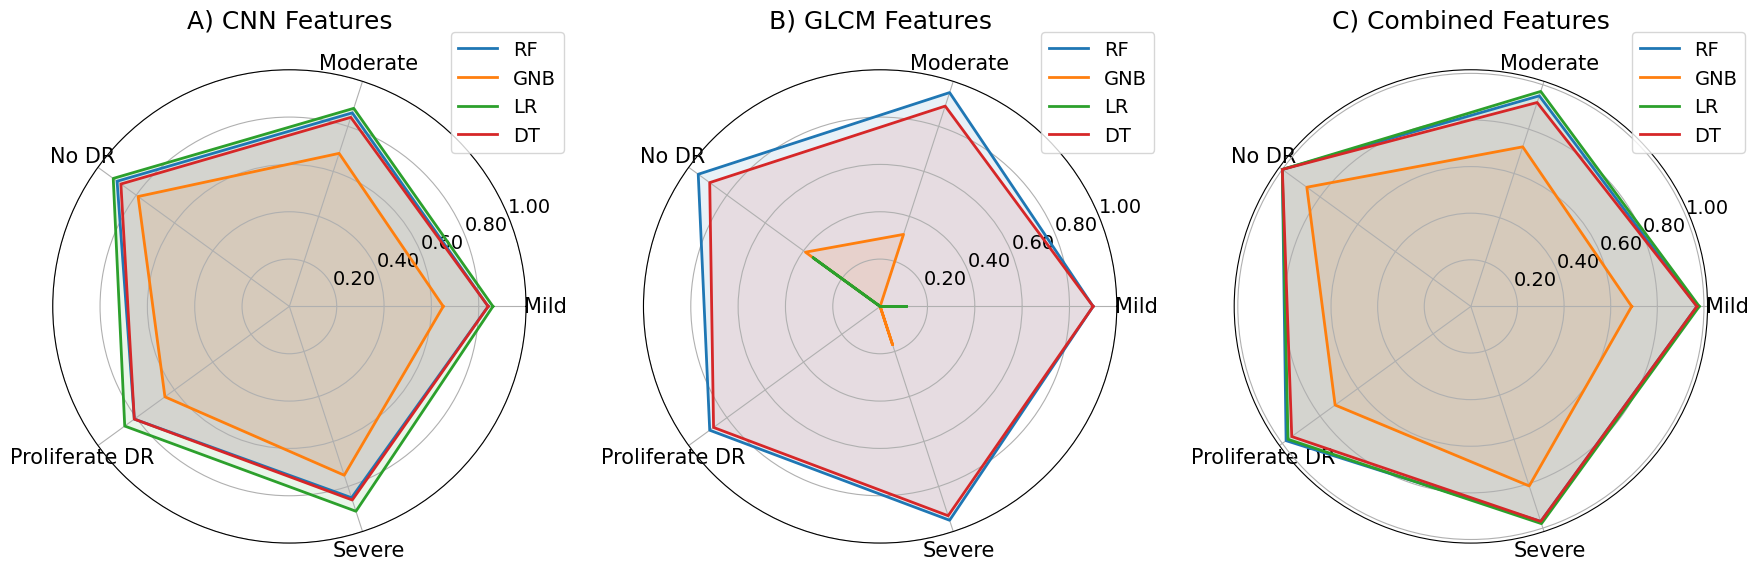

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example F1 score data for models (replace with actual F1 scores)
models = ['RF', 'GNB', 'LR', 'DT']
class_labels = ['Mild', 'Moderate', 'No DR', 'Proliferate DR', 'Severe']
num_vars = len(class_labels)

# F1 score values for each model and feature set
f1_values = {
    'CNN Features': {
        'RF': [0.84, 0.86, 0.90, 0.81, 0.85],
        'GNB': [0.65, 0.68, 0.79, 0.65, 0.75],
        'LR': [0.86, 0.88, 0.92, 0.86, 0.91],
        'DT': [0.84, 0.84, 0.88, 0.81, 0.86]
    },
    'GLCM Features': {
        'RF': [0.90, 0.95, 0.95, 0.89, 0.95],
        'GNB': [0.00, 0.32, 0.39, 0.00, 0.17],
        'LR': [0.11, 0.00, 0.35, 0.00, 0.00],
        'DT': [0.90, 0.89, 0.89, 0.87, 0.93]
    },
    'Combined Features': {
        'RF': [0.97, 0.95, 1.00, 0.98, 0.97],
        'GNB': [0.69, 0.72, 0.87, 0.72, 0.81],
        'LR': [0.98, 0.97, 1.00, 0.97, 0.98],
        'DT': [0.97, 0.92, 1.00, 0.95, 0.97]
    }
}

# Compute angles for radar chart (one per class)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 8), subplot_kw=dict(polar=True))

# Generate radar chart for each feature set
for i, feature_set in enumerate(['CNN Features', 'GLCM Features', 'Combined Features']):
    ax = axes[i]

    for model, f1 in f1_values[feature_set].items():
        f1_looped = f1 + f1[:1]  # close the loop
        ax.plot(angles, f1_looped, label=model, linewidth=2)
        ax.fill(angles, f1_looped, alpha=0.1)

    # Customize axis
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.20', '0.40', '0.60', '0.80', '1.00'], fontsize=14)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(class_labels, fontsize=15)
    ax.set_title(f'{chr(65+i)}) {feature_set}', fontsize=18, pad=30)

    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize=14)

# Final layout adjustments
plt.tight_layout(pad=2.0)
plt.savefig('f1_score_plot.png', dpi=300, bbox_inches='tight')
plt.show()
